In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import squidpy as sq
from skimage import io
import scanpy as sc

In [3]:
from napari_spongepy import functions as fc

# Read in the data 
The first step of the analysis includes defining the paths to both the DAPI stained image and the list of the coordinates for each transcript. 

Afterwards, the image is read in, and is seen as a numpy array for the whole analysis.

image is expected to be a tiff file, trancripts location a txt file. 

When working with both nucleus and cellwall images, both paths need to be defined here.  

In [4]:
name_slide = 'A1-1'
path_Coordinates = '../data/resolve/20272_slide1_'+name_slide+'_results.txt'
path_image = "../data/resolve/20272_slide1_"+name_slide+"_DAPI.tiff"
img = io.imread(path_image)

# Processing the image(s)

When working with RESOLVE data, the data is acquired in tiles, and the illumination within a tile isn't always constant. Sometimes one side of a tile is more illuminated than the other, influencing the downstream analysis greatly. RESOLVE assured us this isn't linked to the counts of the transcripts, but this can be checked further on.

Basic is a tool that can correct for this, and is used in this functiosn, the size of a tile, 2144, is hardcoded, and used to defined the tile. 

If you don't see any tiling effects, this step might not be necessary. 

In [13]:
img = fc.BasiCCorrection(img=img)

AttributeError: module 'pybasic' has no attribute 'basic'

The second step of the preprocessing the data includes a couple of steps:

- RESOLVE has missing data on the borders of two tiles, resulting in black lines on the border between tiles. This can split up cells, and thus influence the analysis. 
inpainting this black line circumvents this
- Secondly, a tophatfilter can be added, by defining the size of the tophat filter. If the size of the tophatfilter is not defined, no tophatfilter is added. (I am not sure it actually still is a tophat filter). The goal of this function is to substract background noise, and make the borders of the nuclei cleaner, plus it will delete the occasional debris. If you take the size too small, smaller then the size of your nuclei, the function will create donuts, with black spots in the center of your cells.  If the size of the tophat filter is chosen too big, not enough background is substracted, so a tradeoff should be made. This might need some finetuning. More information can be found on https://biapol.github.io/blog/ryan_savill/03_background_subtraction/. For nuclei, 45-55 is a great starting point. Bigger for whole cells
- Thirdly, this function enhances the contrast, meaning it makes the white and black more separate. It does this by using histogram equalization (CLAHE function). The amount of correction needed can be decided by adapting the contrast_clip value. If the image is already quite bright, 3.5 might be a good starting value. For dark images, you can go up to 10 or even more. 

The result of this function is a cleaned up images, that will give rise to better segmentation results. 


155.77827954292297


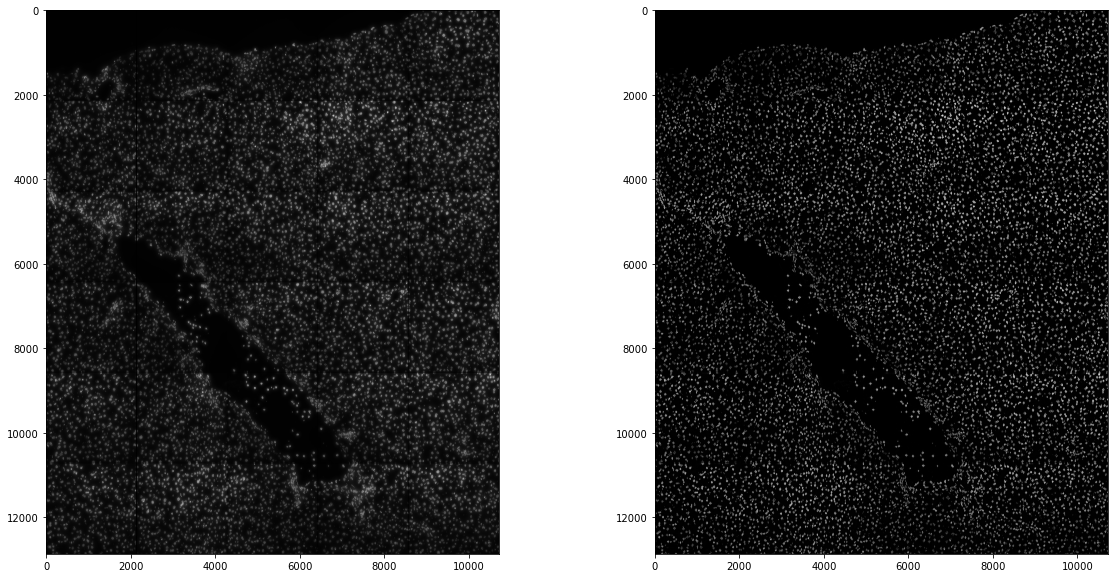

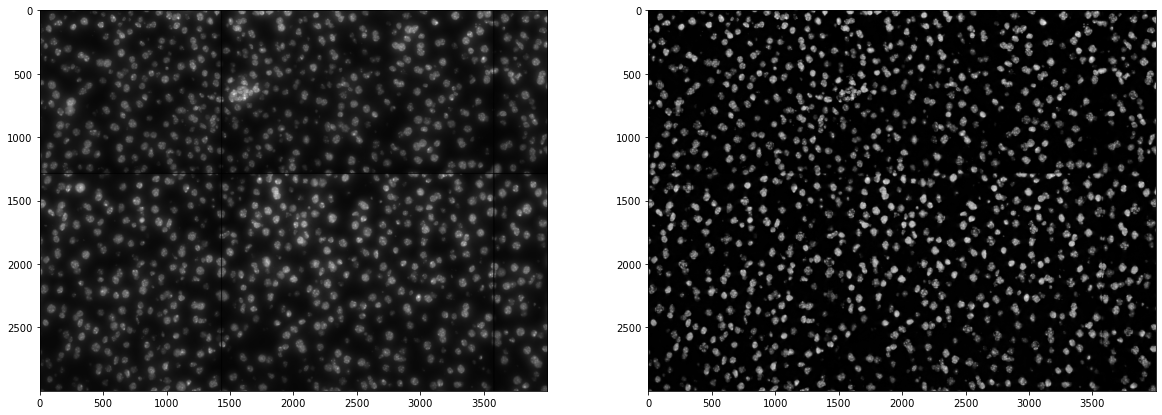

In [5]:
crd = [3000, 6000, 5000, 9000] # a small subset of interest for visualization purposes.
img = fc.preprocessImage(img=img, size_tophat=45, small_size_vis=crd, contrast_clip=3.5)

# Segmenting the image

For the segmentation, we make use of Cellpose, a deep learning network based on a UNET architecture. This is a great tool , because it segments both nuclei and whole cells. 
Multiple paramters need to be given as an inpute to the cellpose algorithm. 
- diameter includes an estimate of the diameter of a nucleus. If put to none, cellpose will do the estimation by himself, but this estimation might take longer than the actual segmentation. You can run the algorthim on a small piece (I[0:1000,0:1000] for example), to get an estimate. However, this estimate isn't always accurate. So check the quality at the end. IF you see all nuclei/cells are estimated too small, enlarge this parameter.
- device defines the device you want to work on, if you only have cpu, you can skip this input parameter. If only having CPU, please tune the parameters on a small subset, and then make it to the big one. This might take a while. If that doesn't work, because of memory issues, you can always split up the image and paste it together, careful with mask numbering though.
- flow_threshold: indicates something about the shape of the masks, if you increase it, more masks with less orund shapes will be accepted. Up to one:  I take it between 0.6 and 0.95
- mask_threshold: indicates how many of the possible masks are kept. MAking it smaller (up to -6), will give you more masks, bigger is less masks. I take it between 0 and -6. Be careful, you can oversegment: always check the quality 
- min_size indicates the minimal size of a nucleus. 
- If segmenting whole cells instead of nuclei, set the parameter model_type to 'cyto'.
- If using nuclei together with whole cells, put model_type to 'cyto', make sure your image is 3D and and that the first channel is you complete cell staining and you second one is the nucleus channel, put the parameter channel to np.array([1,0])

In [ ]:

masks = fc.segmentation(img, device='cuda:4', mask_threshold=-4, flow_threshold=0.9, diameter=50, model_type='nuclei', small_size_vis=crd)

# Creating the anndata object and allocating the transcripts 

In this steps multiple things happen:
- shapes of the different cels in the mask are extracted and saved as a geopandas object. 
- The transcript file is read in  and all transcripts lying in the nuclei/cells are assigend to those nuclei/cells. i should find a new way to add my quality control here. All trancripts outside of the nuclei can be assigned surely to a cell and are thus discarded. Soing diffferently created very messy cells. 
- only cells with transcripts are retained, and the shapes of the cells are added to the anndata in adata.obsm['polygons']


In [ ]:
#path_transcripts="/srv/scratch/lottep/data/PSB/Resolve data/Hormone dataset/pla1 section (mutant)/C1-2_results.txt"
adata = fc.create_adata_quick(path_Coordinates, img, masks)

plot shapes is a funciton that can be used to visualize the cells (and subsets) on the image. by defining the column, the cells can be colored, as we will see later. Alpha defines the see-thoughness to the plotted masks.  

In [ ]:
fc.plot_shapes(adata, crd=[2000, 4000, 2000, 4000], alpha=0.2)

# preprocess adata 

This next code  preprocesses the adata object. 
- calculate QC metrics
- filter cells with less then 10 gene counts and genes with less then 5 cells (adaptations possible by adapting the function)
- Nuc_Size_norm: standard: perform normalization based on the size of the cell/nucleus, followed by scaling. if put to False, normal library size normalazation is performed (not recomendable, but you can check the difference).

The last plot plot the size of the nucleus related to the counts. When working with whole cells, if there are some really big xcells with really low counts, probably they are not real cells, and you should filter based on max size. 


In [ ]:
adata = fc.preprocessAdata(adata, masks)

In [ ]:
fc.plot_shapes(adata, column='total_counts')

In this step you can filter cells base on their size: are you sure cells need to be bigger, or sure your cells can not be larger than X? 

You can delete them with this function by defining min_size and max_size. 

If necessary, this function inclused an extra filter step based on the estimated locations of the cells. The center of the cell is calculated as the mean location of the transcripts allocated to the cell, and as the middle of the shape.
If the distance between both is really large, possibly the shape contains more than only the cell, and the cell is deleted. This isn't used for nucleus segmentation. 

In [ ]:
adata = fc.filter_on_size(adata, min_size=500)

This function performs the neighborhood analysis and the leidne clustering and the UMAP (standard scRNA stuff).

You need to define 2 parameters:
- the amount of PC's used: I normally choose something between 15-20 based on the plot
- The amount of nieghbors used: normally I go for 35. Less neighbors means more spread, more means everything tighter (I think)

It gives back the UMAP and marker gene list per cluster, that can be looked at for finding celltypes. 

In [ ]:
fc.preprocess3(adata, 17, 35)

Here we reuse the plot_shapes function to actually plot a subfigure of our figure with the cells colored based on the clustering.

In [ ]:
fc.plot_shapes(adata, column='leiden', crd=[2000, 4000, 3000, 5000], alpha=0.8)

# Annotating the cells 

In this part of the code we are going to annotate the cells based on marker gene lists. 
The marker geneslist should be a csv with the genes  in the rows and the celltypes in the columns.
If a certain gene is a marker for a certain celltype, the value of the cell should be 1, otherwise it should be zero. 
This matrix is then used to annotate cells.  the path is the input for the function.

All cells are scored for all celltypes. The higher the score the more likely a cell is belonging to a celltype. 

Sometimes some celltypes give way higher scores then others. This is the case in liver for hepatocytes. When you then want readable heatmaps, put the ROwNorm=True.
This normalizes the scores within each cell. 
This will not influence which celltype a cell will get, but will influence the plots. 
However, for some downstream adaptations, you will not want this normalization. 

if not working with liver, you should use the pl.score_genes

In [ ]:
path_mg = '/srv/scratch/lottep/LiverMarkerGenes/markers_including_CD45neg.csv'
mg_dict = fc.score_genes_liver(adata, path_mg)


In liver, the marker genes for hepatocytes are everywhere, but way higher expressed in hepatocytes. This result in a high score for hepatocytes in cells that aren't hepatocytes. 

But those cells score much lower on being hepatocyte then the hepatocytes itselves. So they clearly aren't hepatocytes. 
In the following code we try to estimate how high of a hepatocyte score we actually need to assign a cell hepatocyte. 
In this case it is only necessary for hepatocytes. For melanoma more were necessary. 

We tried other techniques for annotation, such as Tangram too, but they seem to work even less good.
So this is the best we have at the moment. 

In [ ]:
sc.pl.umap(adata, color=['Hepatocytes'])

In [ ]:
adata.obs['Hep'] = (adata.obs['Hepatocytes']>5.6).astype(int)
sc.pl.umap(adata, color=['Hep','Hepatocytes'])

In [ ]:
for i in range(0, len(adata.obs)):
    if adata.obs['Hepatocytes'].iloc[i]<5.6:    
        adata.obs['Hepatocytes'].iloc[i]=adata.obs['Hepatocytes'].iloc[i]/7

This code checks how well the clusters agree with the celltyping, it looks at every cluster and which celltypes are in there; You would want clean columns: one color per column.

When not working with liver, put liver==False

As not al celltypes can be distinguished based on 100 genes, I w-in liver mode combine celltypes. But a better idea would be to adapt the marker genes lists and only include the celltypes you are interested in. 
You can adapt this for your data too. 

Colors can also be adapted per cluster, but this is not an option yet, you would have to adapt the functions for that. 

Beautiful output plots. 

In [ ]:
adata_p = fc.clustercleanliness(adata, img, celltypes=np.array(sorted(list(mg_dict.keys()))), crop_coord=crd, liver=True)

Some adaptations to save the data

In [ ]:
adata.raw.var.index.names = ['genes']
adata.var.index.names = ['genes']
adata.obsm['spatial'] = adata.obsm['spatial'].rename({0: 'X', 1: 'Y'}, axis=1)

Use squidpy to see the enrichement between the different celltypes
For more info, see squidpy!

In [ ]:
sq.gr.spatial_neighbors(adata, coord_type="generic")
sq.gr.nhood_enrichment(adata, cluster_key="maxScores")
sq.pl.nhood_enrichment(adata, cluster_key="maxScores", method="ward")

# Save the objects

As anndata can not save the shapes object, we have to save it separately.
Normally I save the masks separately too, but I forgot that in this notebook. 

In [ ]:
del adata.obsm['polygons']['color']
adata.obsm['polygons']['geometry'].to_file('/srv/scratch/lottep/RESOLVE/Pipeline_Results/adataFilesShort/adataAugust'+name_slide+'.geojson', driver='GeoJSON')
del adata.obsm['polygons']['geometry']
del adata.obsm['polygons']['border_color']
adata.write('/srv/scratch/lottep/RESOLVE/Pipeline_Results/adataFilesShort/adataAugust'+name_slide+'.h5ad')